In [1]:
%config Completer.use_jedi = False

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
land_color = [85/255, 92/255, 105/255]
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=land_color)
plt.rcParams['axes.grid'] = True
import numpy as np
import xarray as xr
import pandas as pd
import gsw, os
etopo = xr.open_dataset('/home1/datawork/kbalem/ETOPO1_Bed_g_gmt4.nc')

### Load GDAC index

In [2]:
ix = pd.read_csv('/home/ref-argo/gdac/ar_index_global_prof.txt', 
                 sep=',', index_col=None, header=0, skiprows=8,
                 names=['file','date','latitude','longitude','ocean','profiler_type','institution','update'], 
                 dtype={'file': np.unicode_, 'latitude': np.float32, 'longitude': np.float32, 'ocean': np.str, 'profiler_type': np.str, 'institution': np.str}
                )
ix.tail()

,file,date,latitude,longitude,ocean,profiler_type,institution,update
2529349,nmdis/2901633/profiles/R2901633_067.nc,2.013050e+13,27.462000,139.106995,P,841,NM,20130507103443
2529350,nmdis/2901633/profiles/R2901633_068.nc,2.013051e+13,27.431999,138.839996,P,841,NM,20130511165723
2529351,nmdis/2901633/profiles/R2901633_069.nc,2.013052e+13,27.691999,138.677002,P,841,NM,20130521170139
2529352,nmdis/2901633/profiles/R2901633_070.nc,2.013053e+13,27.895000,138.464996,P,841,NM,20130531181516
2529353,nmdis/2901633/profiles/R2901633_071.nc,2.013061e+13,27.931000,138.089996,P,841,NM,20130617181801


### Box subset

In [90]:
# region of interest [lonmin, lonmax, latmin, latmax] & float type (here arvor = 844,838)
roi = np.array([-65.0,-5.0,30.0,65.0])
ixs = ix[(ix['latitude']>roi[2])&(ix['latitude']<roi[3]) & 
         (ix['longitude']>roi[0])&(ix['longitude']<roi[1])&
         ((ix['profiler_type']=='844')|(ix['profiler_type']=='838'))]
ixs = ixs.reset_index().drop(columns='index')
ixs['date']= pd.to_datetime(ixs['date'],format='%Y%m%d%H%M%S')
# period of interest [datemin, datemax]
poi = np.array(['2016-01-01','2022-01-01'],dtype='datetime64')
ixs = ixs[(ixs['date']>=poi[0])&(ixs['date']<=poi[1])].reset_index()

# dac generation
dacs = {'AO':'aoml','BO':'bodc','IF':'coriolis','HZ':'csio','CS':'csiro','IN':'incois','JA':'jma','KM':'kma','KO':'kordi','ME':'meds','NM':'nmdis'}
ixs['wmo']=[f.split('/')[1] for f in ixs['file']]
ixs['dac']=[dacs[f] for f in ixs['institution']]
ixs = ixs.groupby('wmo').max().reset_index()
ixs.tail()

,wmo,index,file,date,latitude,longitude,ocean,profiler_type,institution,update,dac
308,7900569,26764,coriolis/7900569/profiles/R7900569_048.nc,2021-10-15 05:35:20,50.153000,-9.528,A,844,IF,20211015063700,coriolis
309,7900570,26813,coriolis/7900570/profiles/R7900570_048.nc,2021-10-15 05:20:20,48.585999,-5.418,A,844,IF,20211021175709,coriolis
310,7900571,26863,coriolis/7900571/profiles/R7900571_049.nc,2021-10-24 05:43:20,51.924000,-12.267,A,844,IF,20211024063456,coriolis
311,7900572,26912,coriolis/7900572/profiles/R7900572_049.nc,2021-10-23 05:32:20,51.867001,-12.990,A,844,IF,20211023065356,coriolis
312,7900573,26962,coriolis/7900573/profiles/R7900573_049.nc,2021-10-20 05:25:20,48.063000,-8.001,A,844,IF,20211020063622,coriolis


### Grounding detection

In [91]:
# HARD MODE, SKIP IF ANY ISSUE
# INIT DS OUT
df = xr.Dataset({"LATITUDE":(["N_PROF"],[]),"LONGITUDE": (["N_PROF"],[]),
                 "WMO": (["N_PROF"],np.array([],dtype='int')),"GROUNDING_DEPTH": (["N_PROF"],[]), 
                 "PROFILE_DEPTH": (["N_PROF"],[]),"GROUNDING_DATE": (["N_PROF"],np.array([],dtype='datetime64')),
                 "PROFILE_DATE": (["N_PROF"],np.array([],dtype='datetime64'))},coords={})

for i in range(len(ixs)):    
    urlt="/home/ref-argo/gdac/dac/"+ixs['dac'][i]+"/"+str(ixs['wmo'][i])+"/"+str(ixs['wmo'][i])+"_Rtraj.nc"   
    urld="/home/ref-argo/gdac/dac/"+ixs['dac'][i]+"/"+str(ixs['wmo'][i])+"/"+str(ixs['wmo'][i])+"_prof.nc"    
    if (os.path.exists(urlt)):
        try:
            dt = xr.open_dataset(urlt)        
            # Check if there's any grounding with the GROUNDED variable
            cycles_grounded = np.argwhere(np.isin(dt['GROUNDED'].values.astype(str),['Y','P','B','C'])).T[0]
            try:
                grounded = dt['CYCLE_NUMBER_INDEX'].values[cycles_grounded]
            except KeyError:
                try:
                    grounded = dt['CYCLE_NUMBER_ACTUAL'].values[cycles_grounded]
                except KeyError:
                    grounded = []
        except:            
            pass
        # IF there's any ...
        if (len(grounded)>0):            
            try:
                dg = dt[['CYCLE_NUMBER','JULD','PRES']].where(dt['MEASUREMENT_CODE']==901.,drop=True).groupby('CYCLE_NUMBER').last()                
                # Here we make sure that grounding occurs in the descent to profile depth and not during parking drift. We do that comparing grounding time 
                # (meas code 901) and parking drift end (meas code 300)
                park_end = dt[['CYCLE_NUMBER','JULD']].where(dt['MEASUREMENT_CODE']==300.,drop=True)
                a = [(dg['JULD'][i].values - park_end['JULD'].where(park_end['CYCLE_NUMBER']==dg['CYCLE_NUMBER'][i],drop=True).values).astype(int)>0 
                     for i in range(len(dg['CYCLE_NUMBER'].values))]
                a = [a[i][0] for i in range(len(dg['CYCLE_NUMBER'].values))]
                dg['grd_on_prf'] = xr.DataArray(a, dims=['CYCLE_NUMBER'])
                dg = dg.where(dg['grd_on_prf']==True,drop=True)
                
                dd = xr.open_dataset(urld)
                # PROFILE DATA
                ds = dd.isel(N_PROF=dd['N_PROF'].values[np.isin(dd['CYCLE_NUMBER'].values,
                                                                dg['CYCLE_NUMBER'].values)])[['PRES','JULD','CYCLE_NUMBER',
                                                                                              'LATITUDE','LONGITUDE']].groupby('CYCLE_NUMBER').last()               
                # MAX PRES AND DEPTH CALCULATION for ds and dg
                ds = ds.max('N_LEVELS')
                ds['Z'] = -1*xr.DataArray(gsw.z_from_p(ds['PRES'],ds['LATITUDE']),dims='CYCLE_NUMBER')
                dg['Z'] = -1*xr.DataArray(gsw.z_from_p(dg['PRES'],ds['LATITUDE']),dims='CYCLE_NUMBER')                
                
                dtmp = xr.Dataset({"LATITUDE":("N_PROF",ds['LATITUDE'].values),
                                   "LONGITUDE":("N_PROF",ds['LONGITUDE'].values),
                                   "WMO":("N_PROF",np.zeros_like(ds['LONGITUDE'].values.astype(int))+int(ixs['wmo'][i])),
                                   "GROUNDING_DEPTH": ("N_PROF",dg['Z'].values),
                                   "PROFILE_DEPTH": ("N_PROF",ds['Z'].values),
                                   "GROUNDING_DATE": ("N_PROF",dg['JULD'].values),
                                   "PROFILE_DATE": ("N_PROF",ds['JULD'].values)},coords={})
                    
                df=xr.concat([df,dtmp],dim='N_PROF')
            except:
                #print('issue on : '+urld) 
                pass
# ONE LAST PASS TO RESPECT INTERVALS OF INTEREST            
df = df.where((df['LONGITUDE']>roi[0])&(df['LONGITUDE']<roi[1])&(df['LATITUDE']>roi[2])&(df['LATITUDE']<roi[3]),drop=True)
df = df.where((df['PROFILE_DATE']>=poi[0])&(df['PROFILE_DATE']<=poi[1]),drop=True)
df = df.sortby('PROFILE_DATE')
df            

<xarray.Dataset>
Dimensions:          (N_PROF: 2595)
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE         (N_PROF) float64 52.84 48.93 48.49 ... 50.93 50.58 50.53
    LONGITUDE        (N_PROF) float64 -36.01 -43.68 -20.54 ... -13.8 -35.29
    WMO              (N_PROF) float64 6.902e+06 6.902e+06 ... 6.903e+06
    GROUNDING_DEPTH  (N_PROF) float64 3.488e+03 3.276e+03 ... 3.841e+03
    PROFILE_DEPTH    (N_PROF) float64 3.482e+03 3.271e+03 ... 3.842e+03
    GROUNDING_DATE   (N_PROF) datetime64[ns] 2016-01-08T13:58:00.000000256 .....
    PROFILE_DATE     (N_PROF) datetime64[ns] 2016-01-09T07:05:20 ... 2021-10-...

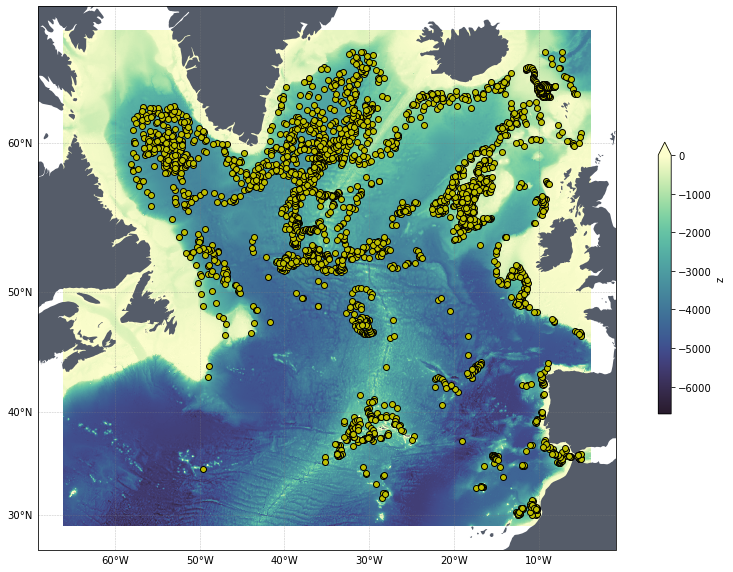

In [92]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)

etopo.where((etopo['x']>roi[0]-1)&(etopo['x']<roi[1]+1)&(etopo['y']>roi[2]-1)&(etopo['y']<roi[3]+1),drop=True)['z'].plot(
    vmax=0,cmap=cmocean.cm.deep_r, cbar_kwargs={'shrink': 0.5},ax=ax, transform=ccrs.PlateCarree())

ax.plot(df['LONGITUDE'],df['LATITUDE'],'oy', markeredgecolor='k', transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

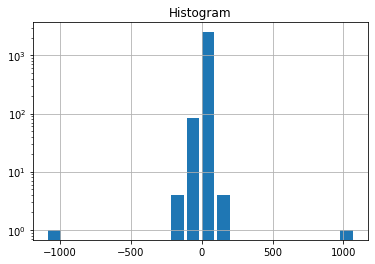

In [118]:
_ = (df['PROFILE_DEPTH']-df['GROUNDING_DEPTH']).plot.hist(bins=20,rwidth=0.8)
plt.gca().set_yscale('log')

In [121]:
# OUTLIERS
df.where(np.abs(df['PROFILE_DEPTH']-df['GROUNDING_DEPTH'])>500,drop=True)

<xarray.Dataset>
Dimensions:          (N_PROF: 2)
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE         (N_PROF) float64 38.49 58.81
    LONGITUDE        (N_PROF) float64 -29.82 -15.37
    WMO              (N_PROF) float64 3.902e+06 6.902e+06
    GROUNDING_DEPTH  (N_PROF) float64 892.3 1.137e+03
    PROFILE_DEPTH    (N_PROF) float64 1.968e+03 42.3
    GROUNDING_DATE   (N_PROF) datetime64[ns] 2019-07-31T03:09:00 2020-03-04T1...
    PROFILE_DATE     (N_PROF) datetime64[ns] 2018-11-28T17:33:29.999999744 20...

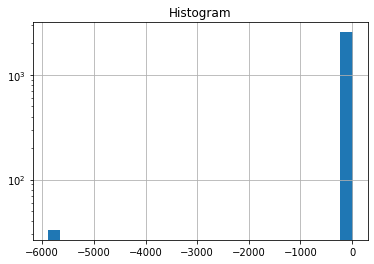

In [122]:
_ = (((df['PROFILE_DATE']-df['GROUNDING_DATE'])).astype(float)/1e9/3600).plot.hist(bins=20,rwidth=0.8)
plt.gca().set_yscale('log')

In [127]:
df.where(((df['PROFILE_DATE']-df['GROUNDING_DATE'])).astype(float)/1e9/3600<-1000,drop=True)

<xarray.Dataset>
Dimensions:          (N_PROF: 33)
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE         (N_PROF) float64 55.82 55.98 56.51 ... 51.22 48.11 47.99
    LONGITUDE        (N_PROF) float64 -9.44 -9.362 -9.193 ... -47.71 -47.28
    WMO              (N_PROF) float64 3.902e+06 3.902e+06 ... 3.902e+06
    GROUNDING_DEPTH  (N_PROF) float64 896.8 697.4 731.9 ... 931.7 0.0 675.2
    PROFILE_DEPTH    (N_PROF) float64 901.8 699.8 749.1 ... 931.6 nan 679.6
    GROUNDING_DATE   (N_PROF) datetime64[ns] 2017-06-15T10:16:00 ... 2021-12-...
    PROFILE_DATE     (N_PROF) datetime64[ns] 2016-10-20T12:50:00 ... 2021-04-...